# Dpa lab


Practice DPA!


### Challenge Name: dpa_setup (/embsec/dpa_lab/dpa_setup)


In this lab we will explore Differential Power Analysis (DPA), with the goal of
setting up an automated framework that we can use in a later lab. Here, our goals
are (1) to become comfortable performing DPA, and (2) create some code that we can
use later to recover a secret key.

For this challenge, we will the 'aes_decrypt_powertraces_test_target.hdf5' file.
This file contains a
large amount of power traces. You will notice (if you poke around in it) that it
has the key. This is so you can use this knowledge to experiment and get to know DPA
better. You still need to write a working solution to this challenge in order to
complete the next one, which won't give you the key.

Finally, notice that you are given decryption traces. This means you will be
recovering the round 10 subkeys. The grader is looking for the initial AES key.
Remember that the inital key is the round 0 AES key, which can be derived from
the round 10 key by running the key schedule backwards. There is code provided
for you to do this.

*Your task* in this challenge is to write some python to evaluate round 10 subkey
candidates. A tip - don't process more than 16 key candidates at a time ... things might
get pretttyyy slow if you do.



0


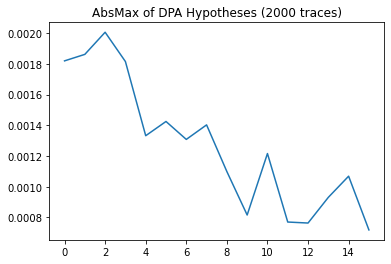

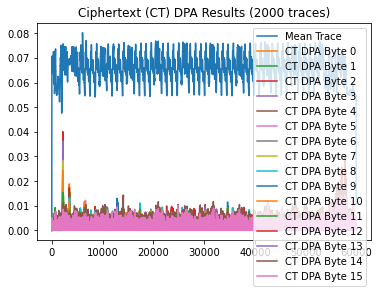

1


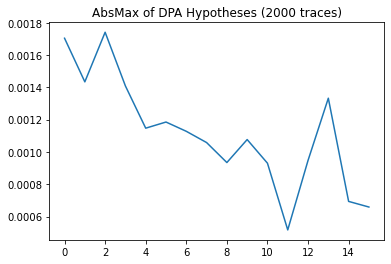

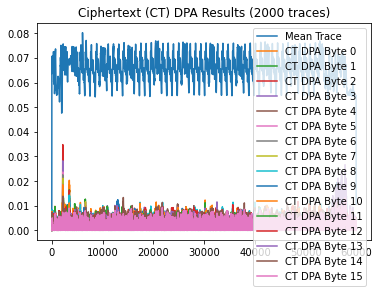

2


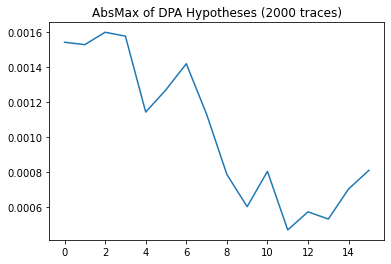

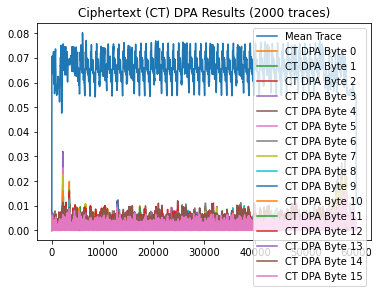

3


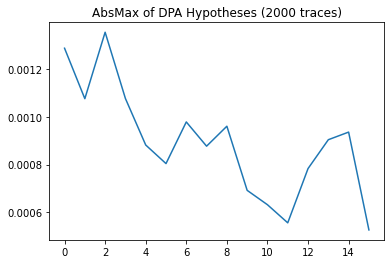

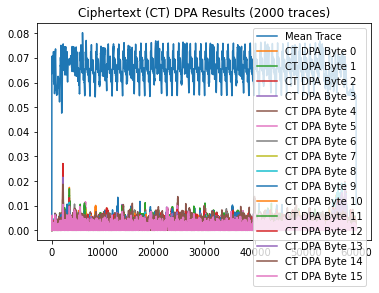

4


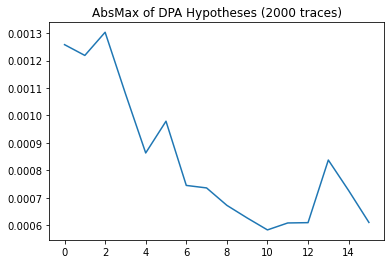

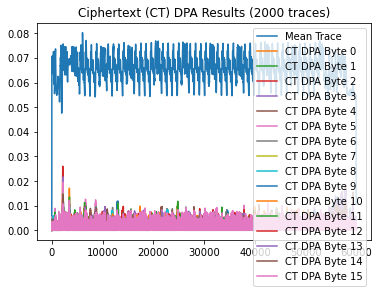

5


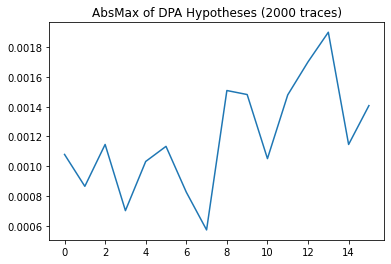

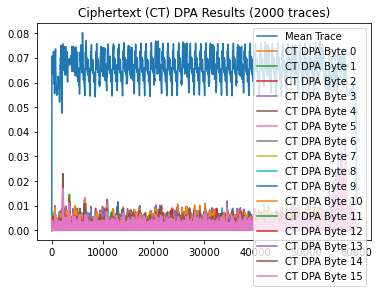

6


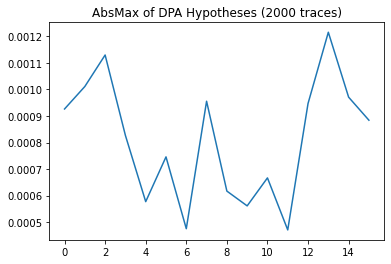

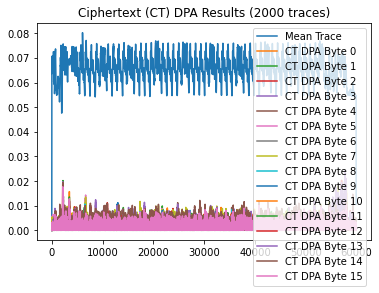

7


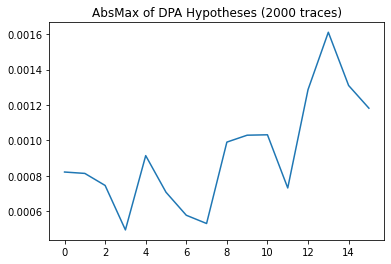

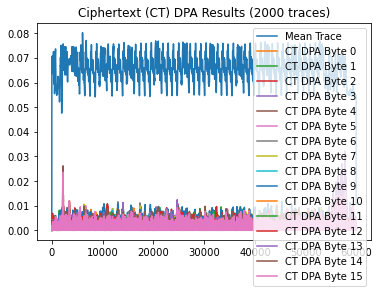

8


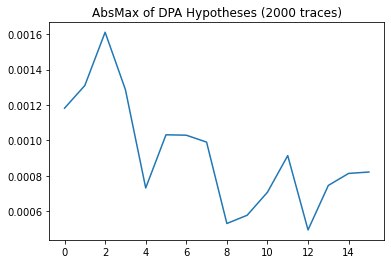

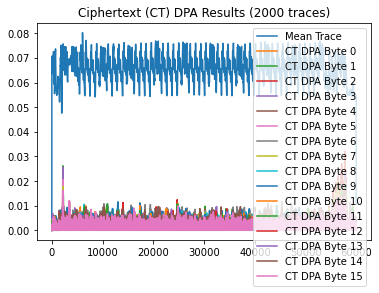

9


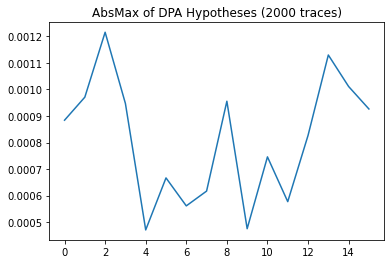

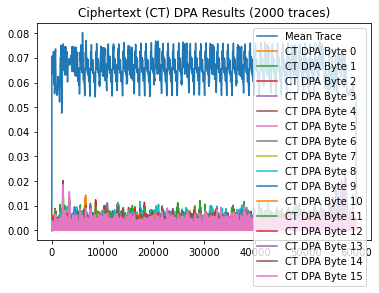

10


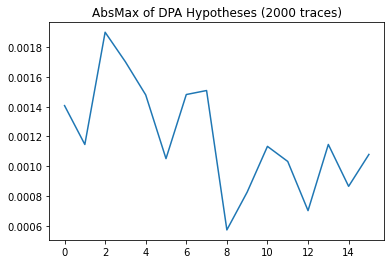

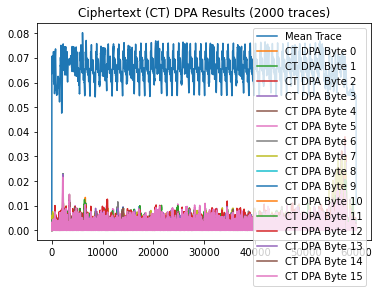

11


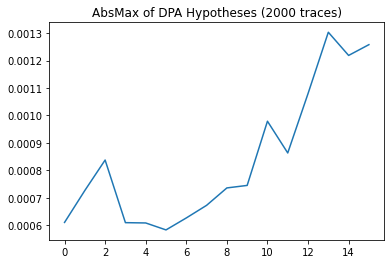

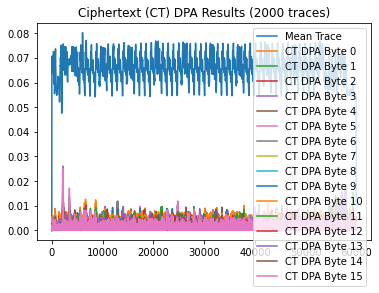

12


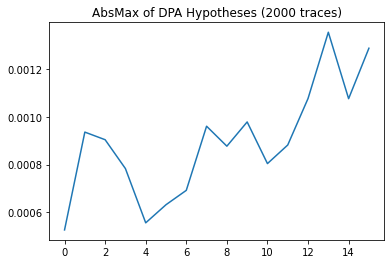

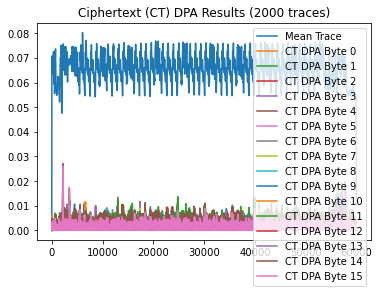

13


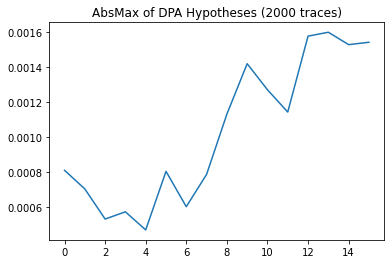

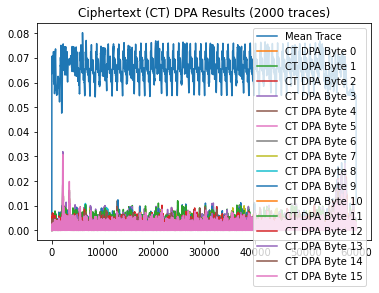

14


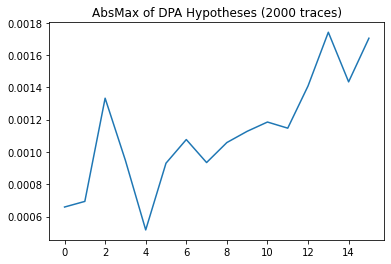

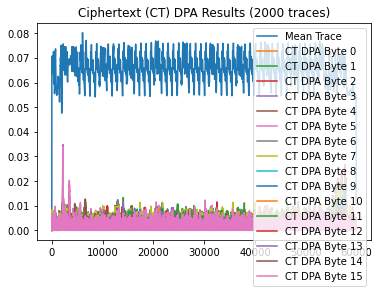

15


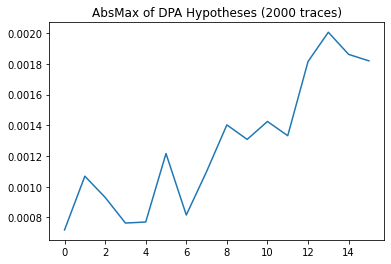

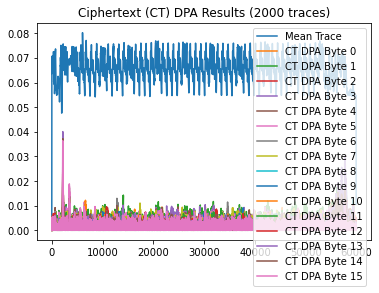

In [21]:
from embsec import Serial
from dpa_utils import *
import numpy as np
import binascii
import h5py
import matplotlib.pyplot as plt

def dpa_setup(ser, i):

    ser = Serial("/embsec/dpa_lab/dpa_setup")


    datafile = h5py.File('aes_decrypt_powertraces_test_target.hdf5', 'r')
    datasets = datafile.keys()

    init = True

    partA_buf = []  # lists of traces in partition A, indexed by key candidate. Individual traces will be numpy arrays!
    partB_buf = []

    partA_cnt = []  # list of number of traces in each partition, indexed by byte under examination
    partB_cnt = []
    avg_buf = None  # average of all traces
    avg_cnt = 0

    trim = False

    skeycan = 0  # the index to the sub-key of the round 10 key we are examining!
    
    # The loop below iterates through all traces in the file, and performs 16 key guesses on
    # the key byte indexed by skeycan. So, this performs DPA for 16 key guesses of just one
    # byte of the (round 10) key. If you want to keep this current code structure, you will
    # need to manually change the for loop bounds to perform more guesses. You will also
    # need to change skeycan to test out other sub-key bytes.
    

    for name in datasets:  # iterate through all traces in the hdf5 file
      #  print("Processing: %s" % name)
        ds = datafile[name]
        trace = np.array(ds)  # this is your current trace! As **a numpy array**
        
        metaname = 'dut_input'
        
        ciphertext_hex = ds.attrs[metaname]
        ciphertext = binascii.unhexlify(ciphertext_hex)

        # If requested, truncate the trace before analysis.
        # This can be used to cut out problematic noisey sections while accelerating
        #  computation and reducing memory needs (great for key attacks)
        if trim:
            trace = trace[:trim]

        if init:  # sets up the partition buffers initially
            for x in range(16):  # just work on 16 possible key bytes, for now.
                partA_buf.append(0 * trace)  # initialize all 'traces' to zero
                partB_buf.append(0 * trace)
                partA_cnt.append(0)
                partB_cnt.append(0)
            avg_buf = 0 * trace
            init = False

      #  i = 2
        for x in range(0, 16):  # just work on 16 key candidates, more is too slow.

            key_guess = 16*i +x
         #   key_guess = x
            
            post_add = ciphertext[skeycan+1] ^key_guess    #inside brackets, do skeycan+n for guessing next bytes, up till +15 bc there are 16 bytes
            
            post_sub = inv_s_box[post_add]
            ham = hamming(post_add)  # hmmm ... is this what we want?

            if ham > 4:
                partA_buf[x] += trace  # add the trace to the list of traces for that key candidate
                partA_cnt[x] += 1  # increment the count for this partition and key candidate
            elif ham < 4:
                partB_buf[x] += trace
                partB_cnt[x] += 1
                pass

        avg_buf += trace
        avg_cnt += 1

    result = dict()

    avg_buf = avg_buf / avg_cnt
    result['avg trace'] = avg_buf
    result['trace cnt'] = avg_cnt

    absmax = []
    for x in range(16):
        means = (partA_buf[x] / partA_cnt[x]) - (partB_buf[x] / partB_cnt[x])
        result[x] = means
        absmax.append(np.max(np.abs(means)))
    result['absmax'] = absmax
    

    # Plot the maximum value of the absolute value of each DPA hypothesis
    plt.figure()
    plt.title("AbsMax of DPA Hypotheses (%d traces)" % result['trace cnt'])
    plt.plot(result['absmax'])    

    # Plot the mean trace and all DPA Ciphertext Byte outputs
    plt.figure()
    plt.plot(result['avg trace'], label='Mean Trace')
    
    dpaPlotScale = 20
    for x in range(16):
        plt.plot(np.abs(result[x]) * dpaPlotScale, label="CT DPA Byte %d" % x)
    plt.legend(loc = 'upper right')
    plt.title("Ciphertext (CT) DPA Results (%d traces)" % result['trace cnt'])
    plt.show()

#     # The next couple lines are to send the key you found / get a flag (if applicable)
#     key_answer = bytes(16) # your key you found! As a byte array
#     ser.write(key_answer)

#     return ser.read_until()

for j in range(16):
    print(j)
    dpa_setup(0, j)



### Challenge Name: dpa_attack (/embsec/dpa_lab/dpa_attack)


Now that we have a feel for a DPA attack, we are going to recover an unknown key from
a different set of traces. This time, use the aes_decrypt_powertraces_firmware_target.hdf5 file.
This file
does not contain the round 10 subkey. It is advisable to use similar code as you did
for the DPA Setup Lab, and to automate the process (which we hope you tried in the last
lab!). Once the key is recovered, send it over serial like you did in the previous lab
to get a flag!



In [ ]:
from embsec import Serial

def dpa_attack():
    ser = Serial("/embsec/dpa_lab/dpa_attack")
    # Your code goes here!

dpa_attack()
